# **Text mining: SENTIMENT ANALYSIS**

## 🎓 Master’s Program in Data Science & Advanced Analytics  
**Nova IMS** | Spring Semester 24/25  
**Course:** Text Mining

## 👥 Team **Group 34**
- **[Diogo Duarte]** | [20240525]
- **[Philippe Dutranoit]** | [20240518]  
- **[Rodrigo Sardinha]** | [20211627]    
- **[Rui Luz]** | [20211628]  

## 📊 Goal of the notebook

This notebook focus on the EDA, giving use a better understanding of what the data looks like and how we could process it in further steps.


---

# **EXPLORATORY DATA ANALYSIS (EDA)**

# 0. Imports

In [111]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords
import re
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [112]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\diogo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [113]:
df_train = pd.read_csv('../Data/train.csv')
df_test = pd.read_csv('../Data/test.csv')

In [114]:
df_train_backup = df_train.copy()

# 1. Train-test Split

In [115]:
X_train, X_val, Y_train, Y_val = train_test_split(
    df_train_backup.drop(columns='label'),
    df_train_backup['label'],
    test_size=0.2,
    random_state=42,
    stratify=df_train_backup['label']
)

In [116]:
Y_train

2186    2
6819    1
6157    0
2462    0
4097    2
       ..
2807    2
704     2
990     1
4362    2
7664    2
Name: label, Length: 7634, dtype: int64

We decided to export the train-test split to a CSV file already, given that this notebook is focused on EDA and not on the model training. This way, the changes made that are more related to interaction with the data can be done here, while the model training can be done from a clean dataset.

In [117]:
X_train.to_csv('../Data/X_train.csv')
X_val.to_csv('../Data/X_val.csv')
Y_train.to_csv('../Data/Y_train.csv')
Y_val.to_csv('../Data/Y_val.csv')

In [118]:
df_eda = pd.concat([X_train, Y_train], axis=1)

# 2. Overview

In [119]:
df_eda.head()

,text,label
2186,Nasdaq prices 600M of 0.875% senior notes,2
6819,Futures up https://t.co/diz7v5lmVb,1
6157,$ECONX: November Nonfarm Private Payrolls 125K...,0
2462,Twitter users explain why Kohl's stock just go...,0
4097,Agilysys : Restaurants Find Sustainable Method...,2


In [120]:
df_eda.info() # from here we get the shape, the data types, and the number of null values in each column

<class 'pandas.core.frame.DataFrame'>
Index: 7634 entries, 2186 to 7664
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7634 non-null   object
 1   label   7634 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 178.9+ KB


# 3. Label (Dependent Feature)

For better interpretation, we will add a new column to the dataset that will contain the label as a string, instead of an integer. This will help us understand the sentiment associated with each review.

In [121]:
labels = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'} # the labels are encoded as 0, 1, 2
df_eda['sentiment'] = df_eda['label'].map(labels)

In [122]:
df_eda['sentiment'].describe()

count        7634
unique          3
top       Neutral
freq         4942
Name: sentiment, dtype: object

In [123]:
df_eda['sentiment'].value_counts()

sentiment
Neutral    4942
Bullish    1538
Bearish    1154
Name: count, dtype: int64

In [124]:
df_eda['sentiment'].value_counts(normalize=True).round(3)

sentiment
Neutral    0.647
Bullish    0.201
Bearish    0.151
Name: proportion, dtype: float64

C:\Users\diogo\AppData\Local\Temp\ipykernel_16888\2050483126.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_eda, x='sentiment', order=df_eda['sentiment'].value_counts().index, palette=colors)


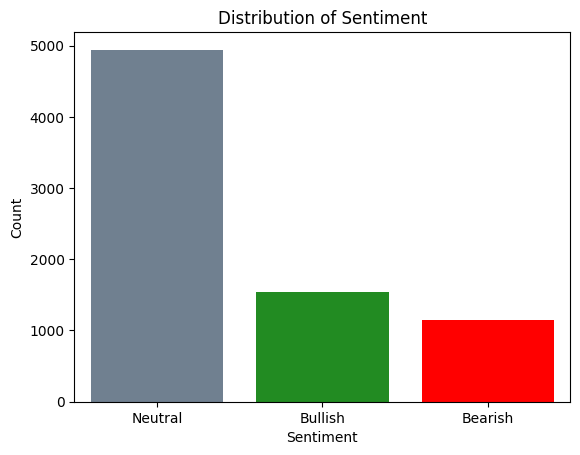

In [125]:
colors = ['slategrey', 'forestgreen', 'red'] # colors for the labels

sns.countplot(data=df_eda, x='sentiment', order=df_eda['sentiment'].value_counts().index, palette=colors)
plt.title("Distribution of Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")

for i, color in enumerate(colors):
    plt.gca().patches[i].set_facecolor(color)

plt.show()

---
## <span style="color: red;">DISCLAIMER</span>
For the purposes of this notebook, we will recode the sentiment labels to enhance the analysis, making them more suitable for our needs. This makes it so that we can classify the sentiments in an ordinal scale, making the feature an ordinal categorical variable, which permits us to perform more interpretation techniques (like boxplots, median, etc.).

In [126]:
# conceptual scale: 0 = Bearish, 1 = Neutral, 2 = Bullish
# this scales the sentiment from negative (Bearish) to positive (Bullish)
concept = {'Bearish': 0, 'Neutral': 1, 'Bullish': 2}

In [127]:
df_eda['scale'] = df_eda['sentiment'].map(concept)

---

In [128]:
desc = df_eda['scale'].describe()
desc = desc.drop(['mean', 'std'])
desc

count    7634.0
min         0.0
25%         1.0
50%         1.0
75%         1.0
max         2.0
Name: scale, dtype: float64

In [129]:
# cummulative absolute frequency table for the scale
cumulative_freq = df_eda['scale'].value_counts().sort_index().cumsum()
cumulative_freq.index = cumulative_freq.index.map({0: 'Bearish', 1: 'Neutral', 2: 'Bullish'})
cumulative_freq

scale
Bearish    1154
Neutral    6096
Bullish    7634
Name: count, dtype: int64

In [130]:
# cummulative relative frequency table for the scale
cumulative_freq = df_eda['scale'].value_counts(normalize=True).round(3).sort_index().cumsum()
cumulative_freq.index = cumulative_freq.index.map({0: 'Bearish', 1: 'Neutral', 2: 'Bullish'})
cumulative_freq

scale
Bearish    0.151
Neutral    0.798
Bullish    0.999
Name: proportion, dtype: float64

<Axes: >

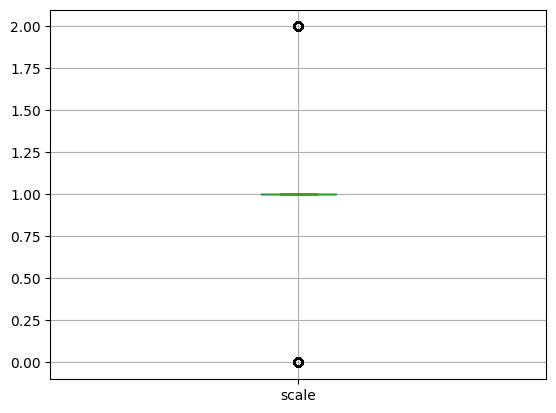

In [131]:
df_eda.boxplot(['scale'])

# 4. Text (Independent Feature)

In [132]:
df_eda['text'][0]

'$BYND - JPMorgan reels in expectations on Beyond Meat https://t.co/bd0xbFGjkT'

### Word Count
Lets start by splitting our texts into tokens and count how many tokens exist in each document.

In [133]:
df_eda['word_count']  = df_eda['text'].apply(lambda x: len(str(x).split(" ")))
df_eda[['text','word_count']].head()

,text,word_count
2186,Nasdaq prices 600M of 0.875% senior notes,7
6819,Futures up https://t.co/diz7v5lmVb,3
6157,$ECONX: November Nonfarm Private Payrolls 125K...,11
2462,Twitter users explain why Kohl's stock just go...,15
4097,Agilysys : Restaurants Find Sustainable Method...,16


In [134]:
df_eda.word_count.describe()

count    7634.000000
mean       12.179329
std         4.647646
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

In [135]:
df_eda[df_eda['word_count'] <= 2]

,text,label,sentiment,scale,word_count
8762,LHC.U,2,Neutral,1,1
3948,@TicToc,2,Neutral,1,1
8805,SBFGP,2,Neutral,1,1
8791,PECK,2,Neutral,1,1
4681,https://t.co/575AH1YRkF,2,Neutral,1,1
8420,BWAY,2,Neutral,1,1
8055,Long $WMT,1,Bullish,2,2
5484,Wholesale Trade,2,Neutral,1,2
8764,LJPC,2,Neutral,1,1
1858,SASA聚酯选用英威达PTA技术,2,Neutral,1,1


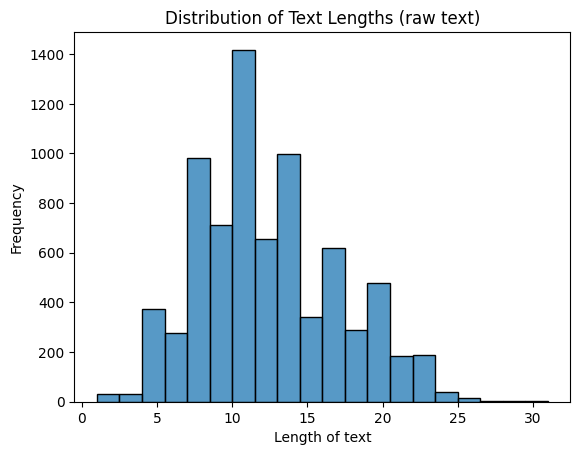

In [136]:
sns.histplot(df_eda['word_count'], bins=20)
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

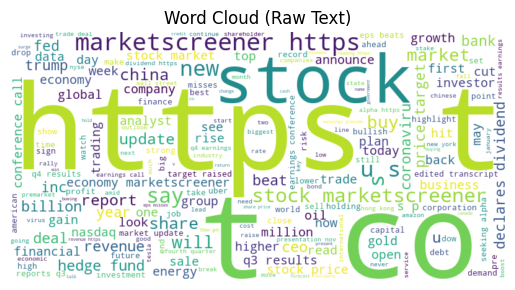

In [137]:
raw_text = ' '.join(df_eda['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [138]:
df_eda['text'][10:20]

1928    Telix Pharmaceuticals : Webcast of CEO present...
8023    Hedge Funds Have Never Been This Bullish On NV...
8963    $ROAD - Construction Partners slips 19% post Q...
342     Upgrades 11/25: $ARWR $CACI $CF $DECK $DKS $EN...
6273    Trump Has Few Options to Juice the Economy Ahe...
8762                                                LHC.U
4732    Investors penalize companies for adding women ...
761     $CBAY: CymaBay Therapeutics halts clinical dev...
2903    Top Earnings Mon 11/25 Aft: $A $AMBA $ARWR $BE...
2176    Junk bond scare is rising: 'No one cares. Peop...
Name: text, dtype: object

In [139]:
# add binary columns "has_link"
df_eda['has_link'] = df_eda['text'].apply(lambda x: 1 if 'http' in str(x) else 0)

In [140]:
df_eda[df_eda['has_link']==1]

,text,label,sentiment,scale,word_count,has_link
6819,Futures up https://t.co/diz7v5lmVb,1,Bullish,2,3,1
6157,$ECONX: November Nonfarm Private Payrolls 125K...,0,Bearish,0,11,1
2462,Twitter users explain why Kohl's stock just go...,0,Bearish,0,15,1
4097,Agilysys : Restaurants Find Sustainable Method...,2,Neutral,1,16,1
8309,$WIRES: On The Wires https://t.co/An35YiKHSC,2,Neutral,1,5,1
...,...,...,...,...,...,...
7496,$GVA: Granite Constr names Kyle Larkin as COO ...,2,Neutral,1,9,1
6056,ICYMI: 81% of U.S. small businesses are 'nonem...,2,Neutral,1,20,1
8165,$BPOP - Popular to review letter from activist...,2,Neutral,1,10,1
2293,$OHI - Omega Healthcare Investors' Risky Divid...,2,Neutral,1,16,1


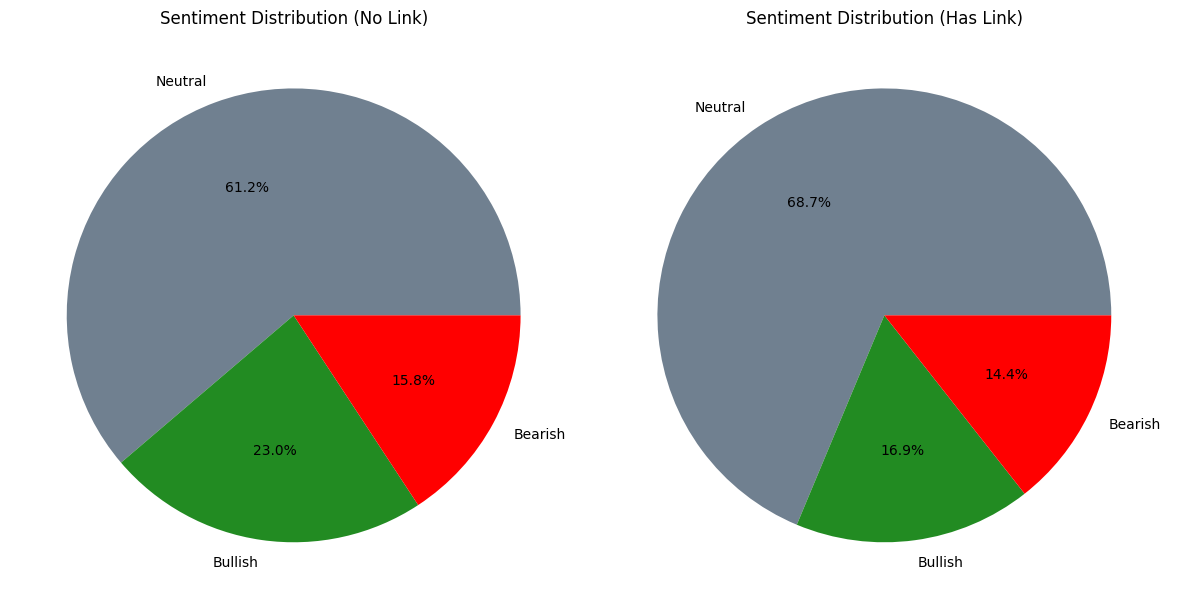

In [141]:
# Pie charts for sentiment distribution by presence of link

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Data for has_link = 0
no_link_counts = df_eda[df_eda['has_link'] == 0]['sentiment'].value_counts()
axes[0].pie(no_link_counts, labels=no_link_counts.index, autopct='%1.1f%%', colors=['slategrey', 'forestgreen', 'red'])
axes[0].set_title('Sentiment Distribution (No Link)')

# Data for has_link = 1
link_counts = df_eda[df_eda['has_link'] == 1]['sentiment'].value_counts()
axes[1].pie(link_counts, labels=link_counts.index, autopct='%1.1f%%', colors=['slategrey', 'forestgreen', 'red'])
axes[1].set_title('Sentiment Distribution (Has Link)')

plt.tight_layout()
plt.show()

# 5. Tokenization

In [142]:
lemmatizer = WordNetLemmatizer() # transform the word to their basic form
STOPWORDS = ENGLISH_STOP_WORDS # remove the common words that do not add much meaning

def clean_text(text: str) -> str:
    """
    Clean the text by:
      1. Lowercasing
      2. Stripping URLs
      3. Stripping @mentions
      4. Stripping # from hashtags
      5. Removing non-alphanumeric (keep spaces)
      6. Collapsing whitespace
      7. Removing stopwords
      8. Lemmatizing (if WordNet is available)
    """
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+|https\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = text.split()
    cleaned = []
    for tok in tokens:
        if tok not in STOPWORDS:
            try:
                cleaned.append(lemmatizer.lemmatize(tok))
            except:
                cleaned.append(tok)
    return ' '.join(cleaned)

In [143]:
updates = df_eda['text'].apply(clean_text)

In [144]:
updates[256]

'huntsman named conviction buy goldman chemical sector shuffle'

In [145]:
df_eda['text'][256]

'Huntsman named Conviction Buy at Goldman in chemical sector shuffle'

In [146]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"text": list_updated}))

In [147]:
update_df(df_eda, updates)
df_eda.head()

,text,label,sentiment,scale,word_count,has_link
2186,nasdaq price 600m 0875 senior note,2,Neutral,1,7,0
6819,future,1,Bullish,2,3,1
6157,econx november nonfarm private payroll 125k v ...,0,Bearish,0,11,1
2462,twitter user explain kohl stock just got oblit...,0,Bearish,0,15,1
4097,agilysys restaurant sustainable method limitin...,2,Neutral,1,16,1


# 6. Bag of Words (BoW)

In [148]:
bow = CountVectorizer(binary=True)
X = bow.fit_transform(df_eda["text"])

In [149]:
print(bow.get_feature_names_out()[10000:10050])  # Display some features

['pta' 'ptab' 'ptc' 'ptct' 'ptm' 'ptn' 'pton' 'ptozf' 'pty' 'pu' 'pub'
 'publ' 'public' 'publica' 'publication' 'publiceert' 'publicis' 'publish'
 'published' 'publisher' 'publishes' 'publishing' 'publix' 'publs' 'puco'
 'puget' 'pull' 'pullback' 'pulled' 'pulling' 'pulp' 'pulse' 'pultegroup'
 'pummeling' 'pump' 'pumped' 'punchup' 'punctured' 'punt' 'pup' 'pura'
 'puration' 'purchase' 'purchased' 'purchasing' 'purdue' 'pure' 'purple'
 'purposeful' 'pursuant']


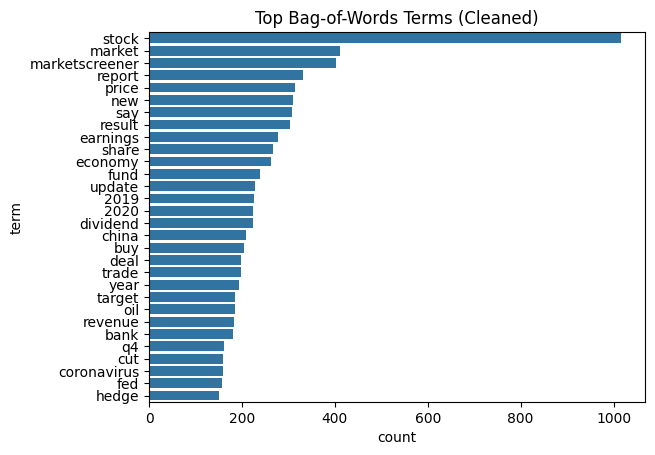

In [150]:
clean_bow_sum = np.array(X.sum(axis=0)).flatten()
clean_terms = bow.get_feature_names_out() # in older versions is get_feature_names()
clean_top = pd.DataFrame({'term': clean_terms, 'count': clean_bow_sum}).sort_values(by='count', ascending=False).head(30)

sns.barplot(data=clean_top, x='count', y='term')
plt.title("Top Bag-of-Words Terms (Cleaned)")
plt.show()

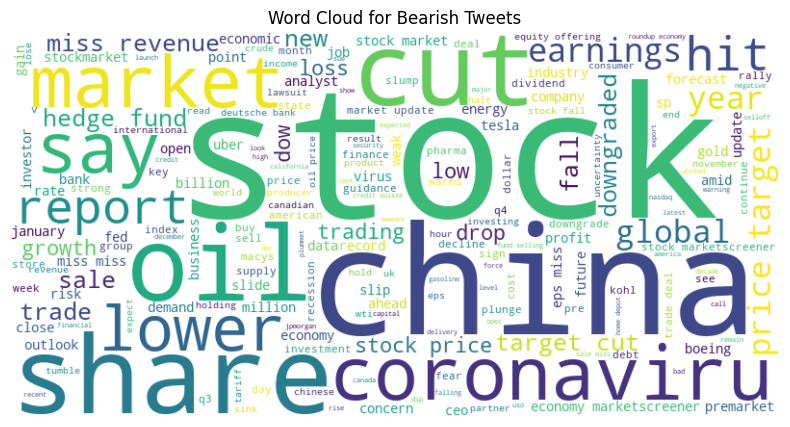

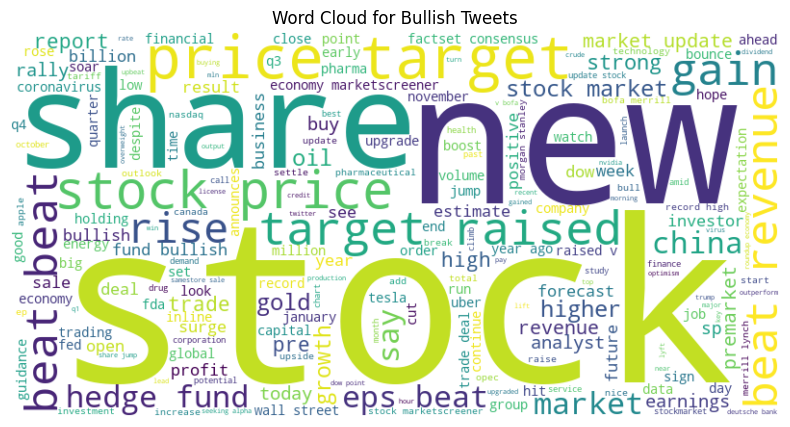

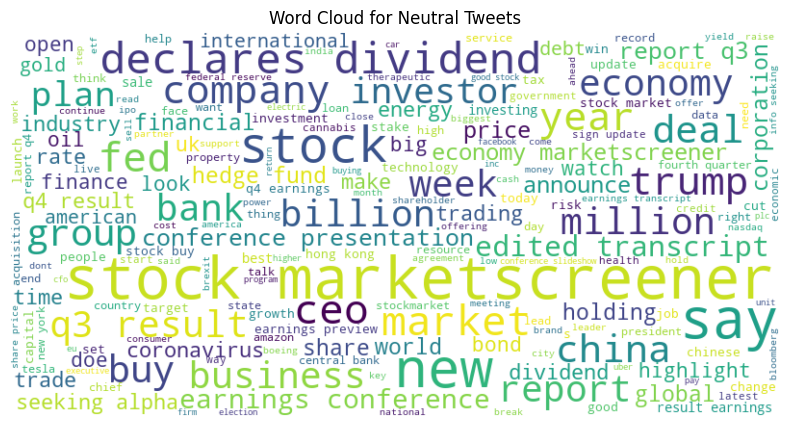

In [151]:
for label, name in zip([0, 1, 2], ['Bearish', 'Bullish', 'Neutral']):
    text = " ".join(df_eda[df_eda['label'] == label]['text'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {name} Tweets')
    plt.show()

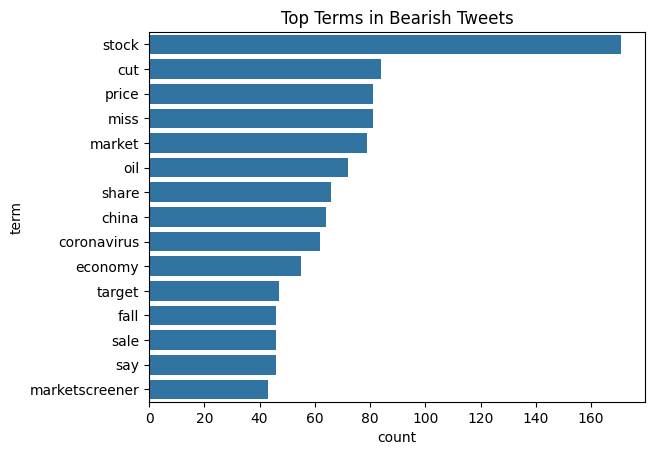

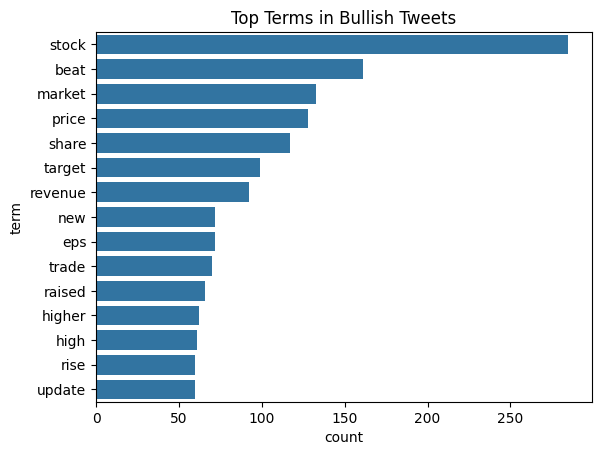

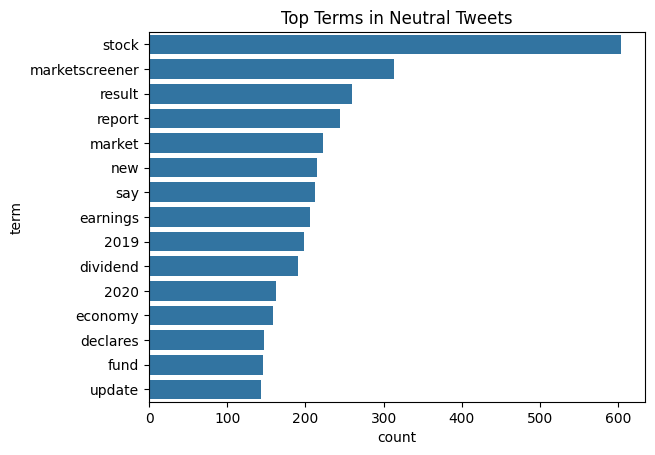

In [152]:
def plot_top_words_by_label(label_value, label_name):
    subset = df_eda[df_eda['label'] == label_value]
    vectorizer = CountVectorizer(stop_words='english', max_features=1000)
    X = vectorizer.fit_transform(subset['text'])
    words = vectorizer.get_feature_names_out()
    freqs = X.toarray().sum(axis=0)
    top_df = pd.DataFrame({'term': words, 'count': freqs}).sort_values(by='count', ascending=False).head(15)
    
    sns.barplot(data=top_df, x='count', y='term')
    plt.title(f"Top Terms in {label_name} Tweets")
    plt.show()

plot_top_words_by_label(0, "Bearish")
plot_top_words_by_label(1, "Bullish")
plot_top_words_by_label(2, "Neutral")